<a href="https://colab.research.google.com/github/Bharathsahil-07/MRI-Image-Segmentation/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Locate Your .rar File


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks"
rar_path = "/content/drive/MyDrive/Colab Notebooks/1RLugSwJu1E3hyuqFTjd2GhQ8hr1aTmqj.rar"



Dataset				      nlp3.ipynb	 Untitled1.ipynb
Dataset.rar			      Pneumonia.ipynb	 Untitled2.ipynb
dld1.ipynb			      predictions.xlsx	 Untitled3.ipynb
GNN-and-PPO-based-Lunar-Landing-main  training_fre.xlsx  Untitled4.ipynb
nlp1.ipynb			      Untitled		 Untitled5.ipynb
nlp2.ipynb			      Untitled0.ipynb


Install unrar Utility

In [ ]:
!apt-get install unrar -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


Extract the .rar File

In [ ]:
import os

# ✅ Correct file path (based on your Drive content)
rar_path = "/content/drive/MyDrive/Colab Notebooks/Dataset.rar"

# ✅ Destination directory for extracted dataset
extract_dir = "/content/drive/MyDrive/Capstone_Project/Dataset"
os.makedirs(extract_dir, exist_ok=True)

# ✅ Confirm both paths before extraction
print("RAR file path:", rar_path)
print("Extract destination:", extract_dir)

# ✅ Extract the .rar file using unrar
!apt-get install unrar -y
!unrar x "$rar_path" "$extract_dir/"


RAR file path: /content/drive/MyDrive/Colab Notebooks/Dataset.rar
Extract destination: /content/drive/MyDrive/Capstone_Project/Dataset
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/Dataset.rar


Would you like to replace the existing file /content/drive/MyDrive/Capstone_Project/Dataset/case_1 - normal/Train/3YGNM1PN_0001.png
 78857 bytes, modified on 2025-10-10 05:10
with a new one
 78857 bytes, modified on 2021-10-17 17:10

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit quit

Program aborted


Imports and Folder Setup

In [ ]:
import os

base_dir = "/content/drive/MyDrive/Capstone_Project/Dataset"

# Case folder mappings
case_pairs = [
    ("case_1 - normal", "mask_case_1 - normal"),
    ("case_2 - LVH", "mask_case_2 - LVH"),
    ("case_3 - CHF", "mask_case_3 - CHF"),
    ("case_4 - CAD", "mask_case_4 - CAD")
]

# Augmented & preprocessed output folders
augmented_base = "/content/drive/MyDrive/Capstone_Project/Augmented_Images"
preprocessed_base = "/content/drive/MyDrive/Capstone_Project/Preprocessed_Images"
os.makedirs(augmented_base, exist_ok=True)
os.makedirs(preprocessed_base, exist_ok=True)


Data Augmentation

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation generator (same for image & mask)
datagen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

for (case, mask_case) in case_pairs:
    print(f"\n🔄 Augmenting pair: {case} ↔ {mask_case}")

    image_dir = os.path.join(base_dir, case)
    mask_dir = os.path.join(base_dir, mask_case)

    aug_image_dir = os.path.join(augmented_base, case)
    aug_mask_dir = os.path.join(augmented_base, mask_case)
    os.makedirs(aug_image_dir, exist_ok=True)
    os.makedirs(aug_mask_dir, exist_ok=True)

    image_names = sorted(os.listdir(image_dir))
    mask_names = sorted(os.listdir(mask_dir))

    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(np.expand_dims(mask, axis=-1), axis=0)

        seed = np.random.randint(10000)
        img_gen = image_datagen.flow(img, batch_size=1, seed=seed,
                                     save_to_dir=aug_image_dir,
                                     save_prefix="aug_" + os.path.splitext(img_name)[0],
                                     save_format="jpg")
        mask_gen = mask_datagen.flow(mask, batch_size=1, seed=seed,
                                     save_to_dir=aug_mask_dir,
                                     save_prefix="aug_" + os.path.splitext(mask_name)[0],
                                     save_format="jpg")

        for i in range(3):  # 3 augmented versions per pair
            next(img_gen)
            next(mask_gen)

print("\n✅ Augmentation complete for all cases & masks!")



🔄 Augmenting pair: case_1 - normal ↔ mask_case_1 - normal

🔄 Augmenting pair: case_2 - LVH ↔ mask_case_2 - LVH

🔄 Augmenting pair: case_3 - CHF ↔ mask_case_3 - CHF

🔄 Augmenting pair: case_4 - CAD ↔ mask_case_4 - CAD

✅ Augmentation complete for all cases & masks!


Preprocessing Function (Model Readiness)


In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    img = cv2.medianBlur(img, 5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = img.astype(np.float32) / 255.0
    return img

def preprocess_mask(mask_path, target_size=(256, 256)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    mask = cv2.resize(mask, target_size)
    mask = (mask > 127).astype(np.uint8)  # binary mask (0 or 1)
    return mask


Apply Preprocessing to Augmented Images

In [ ]:
for (case, mask_case) in case_pairs:
    print(f"\n✨ Preprocessing pair: {case} ↔ {mask_case}")

    aug_image_dir = os.path.join(augmented_base, case)
    aug_mask_dir = os.path.join(augmented_base, mask_case)

    pre_image_dir = os.path.join(preprocessed_base, case)
    pre_mask_dir = os.path.join(preprocessed_base, mask_case)
    os.makedirs(pre_image_dir, exist_ok=True)
    os.makedirs(pre_mask_dir, exist_ok=True)

    for img_name, mask_name in zip(sorted(os.listdir(aug_image_dir)), sorted(os.listdir(aug_mask_dir))):
        img_path = os.path.join(aug_image_dir, img_name)
        mask_path = os.path.join(aug_mask_dir, mask_name)

        img = preprocess_image(img_path)
        mask = preprocess_mask(mask_path)

        if img is not None and mask is not None:
            # Save preprocessed images as float32 or float64 to preserve normalized values
            np.save(os.path.join(pre_image_dir, os.path.splitext(img_name)[0] + '.npy'), img)
            cv2.imwrite(os.path.join(pre_mask_dir, mask_name), (mask * 255).astype(np.uint8)) # Mask can be saved as uint8

print("\n✅ Preprocessing complete for all augmented image-mask pairs!")


✨ Preprocessing pair: case_1 - normal ↔ mask_case_1 - normal

✨ Preprocessing pair: case_2 - LVH ↔ mask_case_2 - LVH

✨ Preprocessing pair: case_3 - CHF ↔ mask_case_3 - CHF

✨ Preprocessing pair: case_4 - CAD ↔ mask_case_4 - CAD

✅ Preprocessing complete for all augmented image-mask pairs!


Preview Sample Images

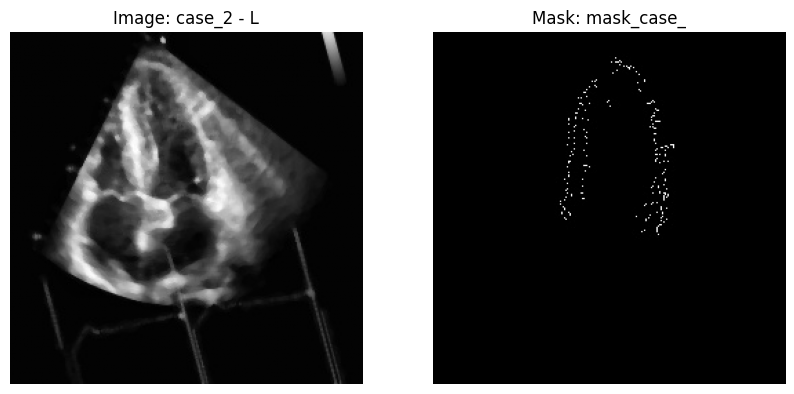

In [ ]:
import random
import matplotlib.pyplot as plt

pair = random.choice(case_pairs)
img_case, mask_case = pair
img_dir = os.path.join(preprocessed_base, img_case)
mask_dir = os.path.join(preprocessed_base, mask_case)

img_name = random.choice(os.listdir(img_dir))
mask_name = random.choice(os.listdir(mask_dir))

img = cv2.imread(os.path.join(img_dir, img_name), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title(f"Image: {img_case[:10]}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title(f"Mask: {mask_case[:10]}")
plt.axis('off')
plt.show()


Imports + settings (run first)

In [ ]:
# Run in Colab (GPU recommended)
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("TF version:", tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Paths - adjust if your structure differs
PREPROC_BASE = "/content/drive/MyDrive/Capstone_Project/Preprocessed_Images"

# Image size used earlier
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
SEED = 42

# Ensure deterministic shuffling for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


TF version: 2.19.0


Collect image-mask pairs (assumes naming consistency)

In [ ]:
# Build lists of image and mask paths by case pairs
case_pairs = [
    ("case_1 - normal", "mask_case_1 - normal"),
    ("case_2 - LVH",    "mask_case_2 - LVH"),
    ("case_3 - CHF",    "mask_case_3 - CHF"),
    ("case_4 - CAD",    "mask_case_4 - CAD"),
]

image_paths = []
mask_paths = []

for img_case, mask_case in case_pairs:
    img_dir = os.path.join(PREPROC_BASE, img_case)
    mask_dir = os.path.join(PREPROC_BASE, mask_case)
    # gather files (jpg/png); keep sorted to align pairs if names match
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    # choose min length to avoid mismatch
    n = min(len(imgs), len(masks))
    image_paths += imgs[:n]
    mask_paths += masks[:n]

print("Total pairs found:", len(image_paths))
# quick sample
for i in range(3):
    print(image_paths[i], "<->", mask_paths[i])


Total pairs found: 793
/content/drive/MyDrive/Capstone_Project/Preprocessed_Images/case_2 - LVH/aug_CT9ZMRR5_0001_0_2521.jpg <-> /content/drive/MyDrive/Capstone_Project/Preprocessed_Images/mask_case_2 - LVH/aug_CT9ZMRR5_0001_0_2337.jpg
/content/drive/MyDrive/Capstone_Project/Preprocessed_Images/case_2 - LVH/aug_CT9ZMRR5_0001_0_2941.jpg <-> /content/drive/MyDrive/Capstone_Project/Preprocessed_Images/mask_case_2 - LVH/aug_CT9ZMRR5_0001_0_2521.jpg
/content/drive/MyDrive/Capstone_Project/Preprocessed_Images/case_2 - LVH/aug_CT9ZMRR5_0001_0_3615.jpg <-> /content/drive/MyDrive/Capstone_Project/Preprocessed_Images/mask_case_2 - LVH/aug_CT9ZMRR5_0001_0_3615.jpg


Train/validation split

In [ ]:
# shuffle and split
pairs = list(zip(image_paths, mask_paths))
random.shuffle(pairs)
image_paths, mask_paths = zip(*pairs)
image_paths = list(image_paths); mask_paths = list(mask_paths)

val_frac = 0.15
val_count = int(len(image_paths) * val_frac)

train_images = image_paths[val_count:]
train_masks = mask_paths[val_count:]
val_images = image_paths[:val_count]
val_masks = mask_paths[:val_count]

print("Train:", len(train_images), "Val:", len(val_images))


Train: 675 Val: 118


tf.data pipeline helpers

In [ ]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # 0-1
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    return img  # shape (H,W,1)

def read_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_image(m, channels=1, expand_animations=False)
    m = tf.image.convert_image_dtype(m, tf.float32)   # 0-1
    m = tf.image.resize(m, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # ensure binary
    m = tf.where(m >= 0.5, 1.0, 0.0)
    return m

def load_pair(img_path, mask_path):
    img = read_image(img_path)
    m = read_mask(mask_path)
    return img, m

# augmentation function for training
def augment(img, mask):
    # simple flip/rotate/brightness - keep transformations identical for both
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    # small random rotation
    if tf.random.uniform(()) > 0.7:
        k = tf.random.uniform((), minval=1, maxval=4, dtype=tf.int32)
        img = tf.image.rot90(img, k)
        mask = tf.image.rot90(mask, k)
    # brightness jitter for image only (not mask)
    img = tf.image.random_brightness(img, 0.1)
    return img, mask

def make_dataset(img_paths, mask_paths, batch_size=BATCH_SIZE, augment_flag=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((list(img_paths), list(mask_paths)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths), seed=SEED)
    ds = ds.map(lambda i, m: tf.py_function(func=lambda a,b: load_pair(a.numpy().decode(), b.numpy().decode()), inp=[i,m], Tout=(tf.float32, tf.float32)),
                num_parallel_calls=AUTOTUNE)
    # Above tf.py_function returns tensors that may not have shape info; set shapes:
    ds = ds.map(lambda x, y: (tf.reshape(x, [IMG_SIZE[0], IMG_SIZE[1], 1]), tf.reshape(y, [IMG_SIZE[0], IMG_SIZE[1], 1])),
                num_parallel_calls=AUTOTUNE)
    if augment_flag:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [ ]:
train_ds = make_dataset(train_images, train_masks, augment_flag=True, shuffle=True)
val_ds   = make_dataset(val_images, val_masks, augment_flag=False, shuffle=False)


Dice & IoU metrics + Dice loss

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


Build a U-Net model

In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256,256,1), base_filters=32):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(base_filters, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(base_filters, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = layers.Conv2D(base_filters*16, 3, activation='relu', padding='same')(p4)
    bn = layers.Conv2D(base_filters*16, 3, activation='relu', padding='same')(bn)

    # Decoder
    u1 = layers.Conv2DTranspose(base_filters*8, 2, strides=2, padding='same')(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(base_filters*4, 2, strides=2, padding='same')(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(c6)

    u3 = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding='same')(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(c7)

    u4 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding='same')(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(base_filters, 3, activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(base_filters, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    return model

model = unet_model((IMG_SIZE[0], IMG_SIZE[1], 1), base_filters=32)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_coef, iou_metric])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Callbacks & Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

checkpoint_path = "/content/drive/MyDrive/Capstone_Project/models/unet_best.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_dice_coef', patience=12, mode='max', restore_best_weights=True, verbose=1)
]

EPOCHS = 50  # You can increase to 30-50 later

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")
print(f"Best model saved to: {checkpoint_path}")


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - dice_coef: 0.0439 - iou_metric: 0.0225 - loss: 0.9561
Epoch 1: val_dice_coef improved from -inf to 0.05746, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - dice_coef: 0.0439 - iou_metric: 0.0226 - loss: 0.9561 - val_dice_coef: 0.0575 - val_iou_metric: 0.0297 - val_loss: 0.9425 - learning_rate: 5.0000e-05
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - dice_coef: 0.0516 - iou_metric: 0.0266 - loss: 0.9484
Epoch 2: val_dice_coef improved from 0.05746 to 0.07015, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - dice_coef: 0.0516 - iou_metric: 0.0266 - loss: 0.9484 - val_dice_coef: 0.0702 - val_iou_metric: 0.0367 - val_loss: 0.9298 - learning_rate: 5.0000e-05
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - dice_coef: 0.0631 - iou_metric: 0.0328 - loss: 0.9369
Epoch 3: val_dice_coef improved from 0.07015 to 0.07477, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step - dice_coef: 0.0631 - iou_metric: 0.0329 - loss: 0.9369 - val_dice_coef: 0.0748 - val_iou_metric: 0.0391 - val_loss: 0.9253 - learning_rate: 5.0000e-05
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coef: 0.0692 - iou_metric: 0.0361 - loss: 0.9308
Epoch 4: val_dice_coef improved from 0.07477 to 0.07530, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - dice_coef: 0.0692 - iou_metric: 0.0361 - loss: 0.9308 - val_dice_coef: 0.0753 - val_iou_metric: 0.0395 - val_loss: 0.9248 - learning_rate: 5.0000e-05
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - dice_coef: 0.0713 - iou_metric: 0.0371 - loss: 0.9287
Epoch 5: val_dice_coef improved from 0.07530 to 0.07925, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - dice_coef: 0.0713 - iou_metric: 0.0371 - loss: 0.9287 - val_dice_coef: 0.0792 - val_iou_metric: 0.0417 - val_loss: 0.9208 - learning_rate: 5.0000e-05
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - dice_coef: 0.0702 - iou_metric: 0.0366 - loss: 0.9298
Epoch 6: val_dice_coef did not improve from 0.07925
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - dice_coef: 0.0702 - iou_metric: 0.0365 - loss: 0.9298 - val_dice_coef: 0.0749 - val_iou_metric: 0.0391 - val_loss: 0.9251 - learning_rate: 5.0000e-05
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - dice_coef: 0.0723 - iou_metric: 0.0377 - loss: 0.9277
Epoch 7: val_dice_coef did not improve from 0.07925
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - dice_coef: 0.0722 - iou_metric: 0.0377 - loss: 0.9278 - val_dice_coef: 0.0335 - val_iou_metric: 0.0171 - val_loss: 0.9668 - learning_rate: 5.0000e-05
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - dice_coef: 0.0702 - iou_metric: 0.0366 - los

85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - dice_coef: 0.0702 - iou_metric: 0.0366 - loss: 0.9297 - val_dice_coef: 0.0908 - val_iou_metric: 0.0478 - val_loss: 0.9094 - learning_rate: 5.0000e-05
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - dice_coef: 0.0735 - iou_metric: 0.0384 - loss: 0.9265
Epoch 9: val_dice_coef did not improve from 0.09078
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - dice_coef: 0.0735 - iou_metric: 0.0385 - loss: 0.9265 - val_dice_coef: 0.0900 - val_iou_metric: 0.0475 - val_loss: 0.9100 - learning_rate: 5.0000e-05
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coef: 0.0855 - iou_metric: 0.0451 - loss: 0.9145
Epoch 10: val_dice_coef improved from 0.09078 to 0.09338, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - dice_coef: 0.0855 - iou_metric: 0.0451 - loss: 0.9145 - val_dice_coef: 0.0934 - val_iou_metric: 0.0492 - val_loss: 0.9065 - learning_rate: 5.0000e-05
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - dice_coef: 0.0817 - iou_metric: 0.0429 - loss: 0.9183
Epoch 11: val_dice_coef improved from 0.09338 to 0.09963, saving model to /content/drive/MyDrive/Capstone_Project/models/unet_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step - dice_coef: 0.0817 - iou_metric: 0.0430 - loss: 0.9183 - val_dice_coef: 0.0996 - val_iou_metric: 0.0526 - val_loss: 0.9001 - learning_rate: 5.0000e-05
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - dice_coef: 0.0882 - iou_metric: 0.0465 - loss: 0.9118
Epoch 12: val_dice_coef did not improve from 0.09963
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - dice_coef: 0.0882 - iou_metric: 0.0465 - loss: 0.9118 - val_dice_coef: 1.2875e-05 - val_iou_metric: 6.4381e-06 - val_loss: 1.0000 - learning_rate: 5.0000e-05
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - dice_coef: 1.9456e-10 - iou_metric: 1.9456e-10 - loss: 1.0000
Epoch 13: val_dice_coef did not improve from 0.09963
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - dice_coef: 1.9463e-10 - iou_metric: 1.9463e-10 - loss: 1.0000 - val_dice_coef: 1.9863e-10 - val_iou_metric: 1.9863e-10 - val_loss: 1.0000 - learning_rate: 5.0000e-05
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_co

Visualize training curves

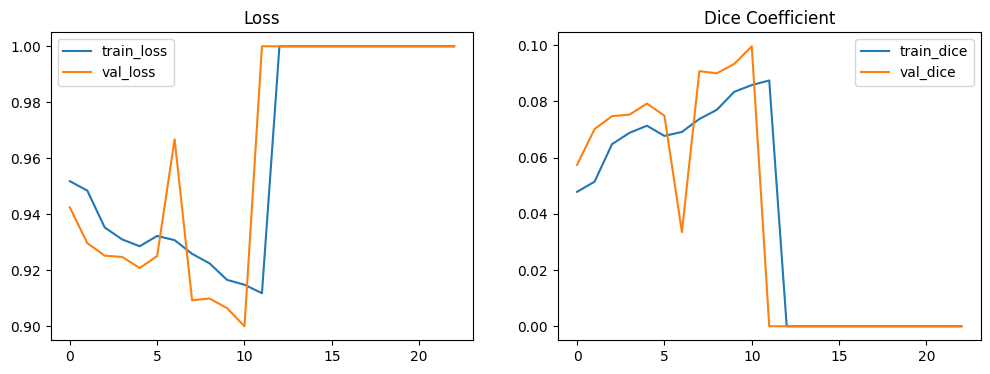

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='train_dice')
plt.plot(history.history['val_dice_coef'], label='val_dice')
plt.legend(); plt.title('Dice Coefficient')
plt.show()


Evaluate & Show sample predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


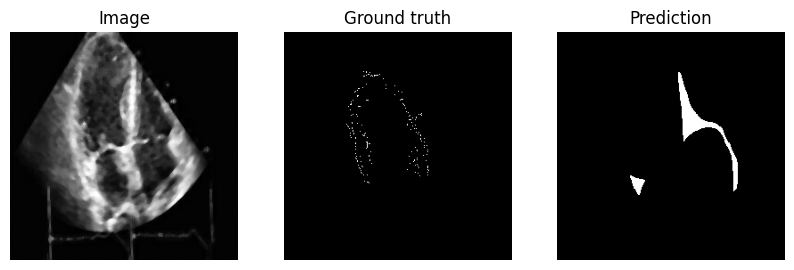

Dice: 0.029481131583452225 IoU: 0.014961102046072483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


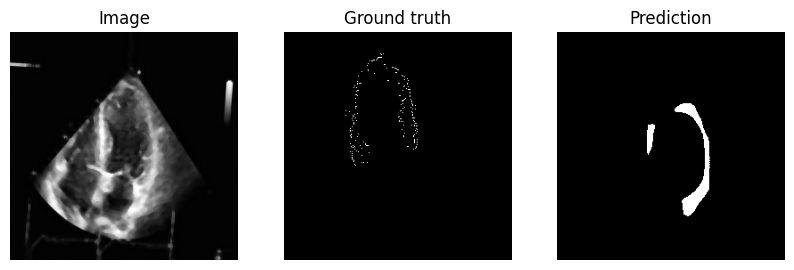

Dice: 0.01311084721237421 IoU: 0.00659868074581027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


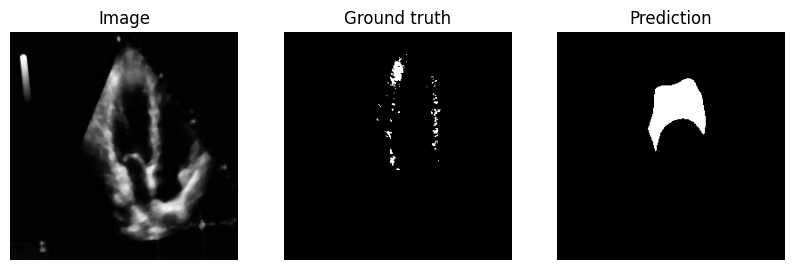

Dice: 0.024743512272834778 IoU: 0.012526733800768852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


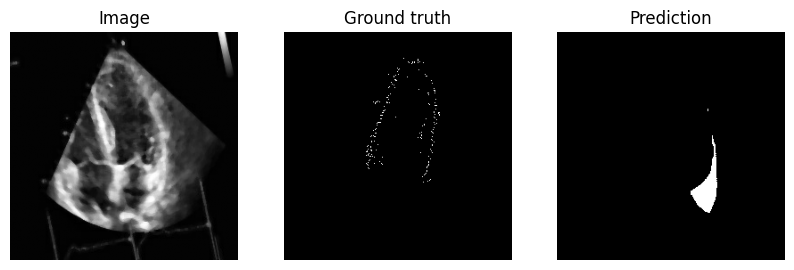

Dice: 8.591065081553495e-10 IoU: 8.591065081553495e-10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


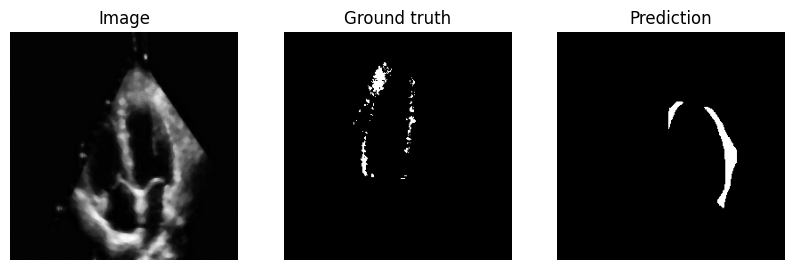

Dice: 5.274261583032569e-10 IoU: 5.274261583032569e-10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


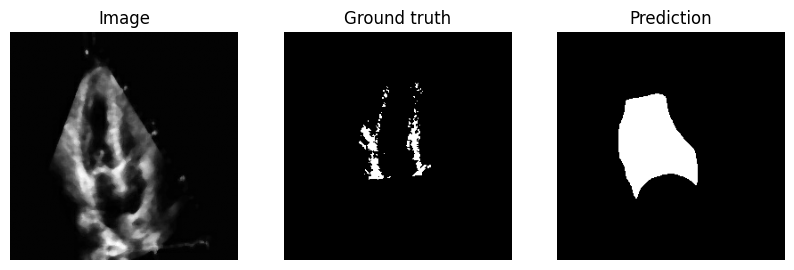

Dice: 0.23693740367889404 IoU: 0.13438966870307922


In [ ]:
# load best model
model.load_weights(checkpoint_path)

# pick a few val examples
n_samples = min(6, len(val_images))
indices = np.random.choice(len(val_images), size=n_samples, replace=False)

for idx in indices:
    img_path = val_images[idx]
    mask_path = val_masks[idx]
    img = read_image(img_path).numpy().squeeze()
    true_mask = read_mask(mask_path).numpy().squeeze()

    pred = model.predict(np.expand_dims(np.expand_dims(img, 0), -1))[0,:,:,0]
    pred_bin = (pred >= 0.5).astype(np.uint8)

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(true_mask, cmap='gray'); plt.title('Ground truth'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_bin, cmap='gray'); plt.title('Prediction'); plt.axis('off')
    plt.show()

    # Convert to float tensors before calculating metrics
    true_mask_float = tf.cast(true_mask, tf.float32)
    pred_bin_float = tf.cast(pred_bin, tf.float32)
    print("Dice:", float(dice_coef(true_mask_float, pred_bin_float).numpy()), "IoU:", float(iou_metric(true_mask_float, pred_bin_float).numpy()))

Save final model & tips

In [ ]:
final_path = "/content/drive/MyDrive/Capstone_Project/models/unet_final.h5"
model.save(final_path)
print("Saved final model to:", final_path)


Saved final model to: /content/drive/MyDrive/Capstone_Project/models/unet_final.h5
